# Curve fitting and generation with `PyTorch`
Author: [Tobias Windisch](http://tobias-windisch.de)

Assume we have given a parametrized function $p_w$, like $p_w(x)=x^2\cdot w_0+w_1\cdot x+w_2$. This notebook wants to find parameters $w$ in an automatized way such that certain conditions of the form

- $p_w(c_p)=d_p$
- $p_w'(c_{dp})=d_{dp}$
- $p_w''(c_{ddp})=d_{ddp}$

by only specifing $p_w$ and by computing and sort of partial derivative automatically with `torch.autograd`.

In [408]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

### Parameters
Lets assume, $p_w=x^5w_0+x^4w_1+x^3w_2+x^2w_3+xw_4+w_5$ and assume we have given condtions of the form

- $p_w(d_0)=c_0$
- $p_w(d_1)=c_1$
- $p_w'(d_2)=c_2$
- $p_w''(d_3)=c_3$

In [427]:
c_p = torch.tensor([0., 1., 5.0], requires_grad=True)
d_p = torch.tensor([0., 4., 0.0])

In [428]:
c_dp = torch.tensor([3.0], requires_grad=True)
d_dp = torch.tensor([3.0])

In [429]:
c_ddp = torch.tensor([3.0], requires_grad=True)
d_ddp = torch.tensor([-3.0])

In [452]:
class Polynomial(nn.Module):
    def __init__(self):
        super(Polynomial, self).__init__()

        w = torch.Tensor(torch.ones(6))
        self.w = nn.Parameter(w)
    
    def forward(self, x):
        return self.w[0]*x**5 + self.w[1]*x**4 + self.w[2]*x**3 + self.w[3]*x**2 + self.w[4]*x+self.w[5]
    
    def first_derivative(self, x):
        return torch.autograd.grad(
            outputs=self(x), 
            inputs=x, 
            grad_outputs=torch.Tensor(torch.ones(x.shape)), 
            retain_graph=True, 
            create_graph=True
        )[0]
    
    def second_derivative(self, x):
        return torch.autograd.grad(
            outputs=self.first_derivative(x), 
            inputs=x, 
            grad_outputs=torch.Tensor(torch.ones(x.shape)), 
            retain_graph=True, 
            create_graph=True
        )[0]


### Testing
Make sure that pytorch gradients coincide with gradients computed manually

In [437]:
poly = Polynomial()

In [438]:
external_grad = torch.ones(c.shape)

In [439]:
dxp_torch = poly.first_derivative(c_p)

In [441]:
ddxp_torch = poly.second_derivative(c_p)

In [442]:
def dxp(w, x):
    return 5*w[0]*x**4 + 4*w[1]*x**3 + 3*w[2]*x**2 + 2*w[3]*x + w[4]

In [443]:
def ddxp(w, x):
    return 20*w[0]*x**3 + 12*w[1]*x**2 + 6*w[2]*x + 2*w[3]

In [444]:
np.testing.assert_array_equal(
    dxp(np.ones(6), c_p.detach().numpy()),
    dxp_torch.detach().numpy()
)

In [445]:
np.testing.assert_array_equal(
    ddxp(np.ones(6), c_p.detach().numpy()),
    ddxp_torch.detach().numpy()
)

## Optimization

In [447]:
def solve(c_p, c_dp, c_ddp, d_p, d_dp, d_ddp, debug=False):
    
    losses = []
    poly = Polynomial()

    optimizer = torch.optim.LBFGS(poly.parameters(), max_iter=4, line_search_fn="strong_wolfe")
    
    def closure():
        px = poly(c_p)
        dpx = poly.first_derivative(c_dp)
        ddpx = poly.second_derivative(c_ddp)

        optimizer.zero_grad()
        loss = ((px- d_p)**2).sum() + ((dpx-d_dp)**2).sum()+((ddpx-d_ddp)**2).sum()
        loss.backward()
        if debug:
            losses.append(loss.detach().numpy())
        return loss
    
    for _ in range(100): 
        optimizer.step(closure)

    return poly, np.array(losses)

In [449]:
poly, losses = solve(c_p, c_dp, c_ddp, d_p, d_dp, d_ddp, debug=True)

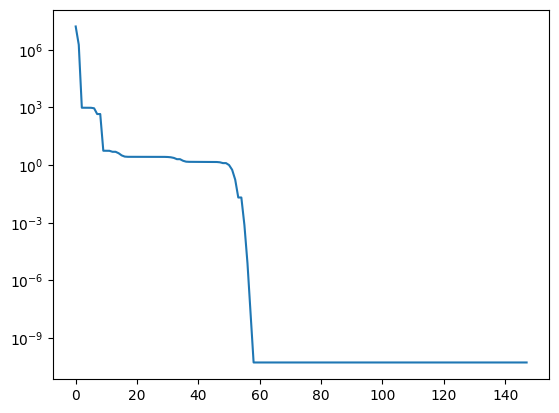

In [450]:
fig, ax = plt.subplots()

ax.plot(np.array(losses))
ax.set_yscale('log')

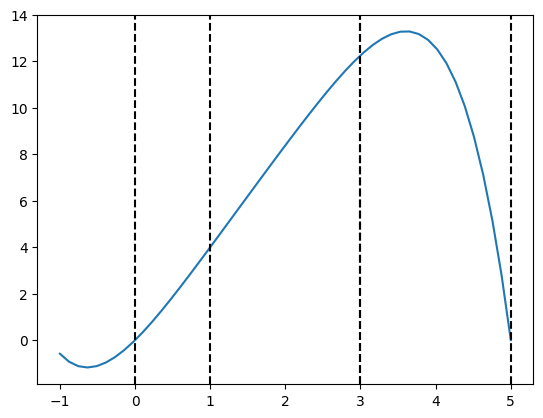

In [451]:
x = torch.from_numpy(np.linspace(-1, 5))
fig, ax = plt.subplots()
ax.plot(x.numpy(), poly(x).detach().numpy())

for cc in c.detach().numpy():
    ax.axvline(cc, linestyle='dashed', color='black')

## Solve with slight random perpurtations

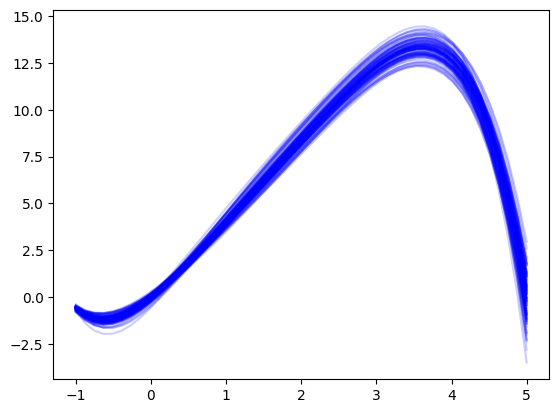

In [470]:
fig, ax = plt.subplots()
x = torch.from_numpy(np.linspace(-1, 5))

for _ in range(100):
    
    c_p_rand = torch.tensor(c_p.detach().numpy() + np.random.normal(size=3, loc=0, scale=0.05), requires_grad=True)
    c_dp_rand = torch.tensor(c_dp.detach().numpy() + np.random.normal(size=1, loc=0, scale=0.05), requires_grad=True)
    
    poly, _ = solve(c_p_rand, c_dp_rand, c_ddp, d_p, d_dp, d_ddp)
    
    ax.plot(x.numpy(), poly(x).detach().numpy(), alpha=0.2, color='blue')